In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

import re
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop,schedules
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, BatchNormalization, ReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,GaussNoise,
    ToFloat, ShiftScaleRotate, Resize, OneOf, MedianBlur, VerticalFlip
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -uq "/content/drive/MyDrive/test_dataset.zip" -d "/content"
!unzip -uq "/content/drive/MyDrive/train_dataset.zip" -d "/content"

In [ ]:
train_path = "/content/train/"
test_path = "/content/test/"

labels = os.listdir(train_path)
labels.sort()
print(labels)

path_list = []
cate_list = []

for label in labels:
  path = train_path + f'{label}/'
  image_list = os.listdir(path)

  for image in  image_list:
    path_list.append(path + f'{image}')
    cate_list.append(label)

data = pd.DataFrame({"path" : path_list, "category" : cate_list})

test_list = [test_path + x for x in os.listdir(test_path)]
pred = pd.DataFrame({"path" : test_list})

print(data["category"].value_counts(normalize=True))


['bart', 'charles_montgomery', 'krusty', 'lisa_simpson', 'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'principal_skinner']
ned_flanders           0.129267
moe_szyslak            0.129090
lisa_simpson           0.120377
marge_simpson          0.116554
bart                   0.108286
principal_skinner      0.106063
krusty                 0.097884
charles_montgomery     0.096550
milhouse_van_houten    0.095928
Name: category, dtype: float64


In [ ]:
img = cv2.imread(data.loc[0]["path"])
print(type(img))
print(img.shape)


<class 'numpy.ndarray'>
(416, 288, 3)


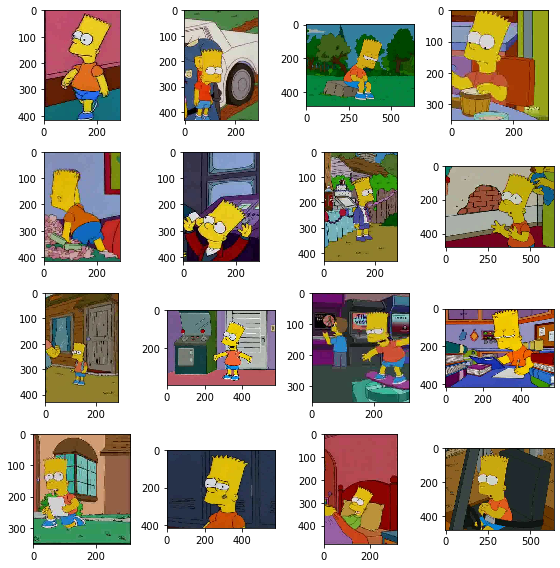

In [ ]:
fig = plt.figure(figsize=(8, 8))

for i in range(16):

    plt.subplot(4, 4, 1 + i)
    plt.tight_layout()

    image_bgr = cv2.imread(data.loc[i]["path"])
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb, cmap="rainbow", interpolation="none")

plt.show()

In [ ]:
data.dtypes

path        object
category    object
dtype: object

In [ ]:
categories = [x for x in labels]
map_characters = {0: 'bart', 1: 'charles_montgomery', 2: 'krusty', 
        3: 'lisa_simpson', 4: 'marge_simpson', 5: 'milhouse_van_houten', 
        6: 'moe_szyslak', 7: 'ned_flanders', 8: 'principal_skinner'}

print(categories)

data["category"] = pd.Categorical(data["category"], categories=categories)
data["category"] = data["category"].cat.codes

print(data.dtypes)
data


['bart', 'charles_montgomery', 'krusty', 'lisa_simpson', 'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'principal_skinner']
path        object
category      int8
dtype: object


,path,category
0,/content/train/bart/pic_0064.jpg,0
1,/content/train/bart/pic_0712.jpg,0
2,/content/train/bart/pic_0678.jpg,0
3,/content/train/bart/pic_0877.jpg,0
4,/content/train/bart/pic_0496.jpg,0
...,...,...
11243,/content/train/principal_skinner/pic_0088.jpg,8
11244,/content/train/principal_skinner/pic_0344.jpg,8
11245,/content/train/principal_skinner/pic_0376.jpg,8
11246,/content/train/principal_skinner/lisa_simpson6...,8


In [ ]:
train, test = train_test_split(data, test_size=0.2, stratify=data["category"])
print(len(train), len(test))

8998 2250


In [ ]:
class DataSequence(Sequence):
  def __init__(self, dataframe, batch_size, augmentations, shuffle):
    self.x = dataframe["path"].values.tolist()
    self.y = dataframe["category"].values.tolist() if len(dataframe.columns) == 2 else None
    self.batch_size = batch_size
    self.augment = augmentations
    self.img_size = (225, 225)
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    return int(np.ceil(len(self.x) / float(self.batch_size)))

  def on_epoch_end(self):
        self.indexes = np.arange(len(self.x))
        if self.shuffle:
            np.random.shuffle(self.indexes)

  def getX(self, idx):
    batch_x = [np.array(cv2.cvtColor(cv2.imread(path), cv2.COLOR_RGB2BGR)) 
              for path in self.x[idx * self.batch_size:(idx + 1) * self.batch_size]]

    return batch_x

  def __getitem__(self, idx):
    batch_x = self.getX(idx)

    if self.y is not None:
      batch_y = np.array(self.y[idx * self.batch_size:(idx + 1) * self.batch_size])
        
      return np.array([
              tf.image.resize(self.augment(image=x)["image"], self.img_size) for x in batch_x
          ], dtype='float32') / 255., np.array(to_categorical(batch_y, 9))
    else :
      return np.array([
              tf.image.resize(self.augment(image=x)["image"], self.img_size) for x in batch_x
          ]) / 255.

In [ ]:
Aug_train = Compose([
                     HorizontalFlip(p=0.5),
                     VerticalFlip(p=0.5),
                     RandomContrast(limit=0.1, p=0.5),
                     RandomGamma(gamma_limit=(80, 120), p=0.5),
                     RandomBrightness(limit=0.1, p=0.1),
                     GaussNoise(always_apply=False, p=0.5),
                     ShiftScaleRotate(
                         shift_limit=0.0625, scale_limit=0.1, 
                         rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.5),
                    MedianBlur(blur_limit=7, p=0.5)
                     #ToFloat(max_value=255)
                     ])

Aug_test = Compose([
                    #ToFloat(max_value=255)
                    ])

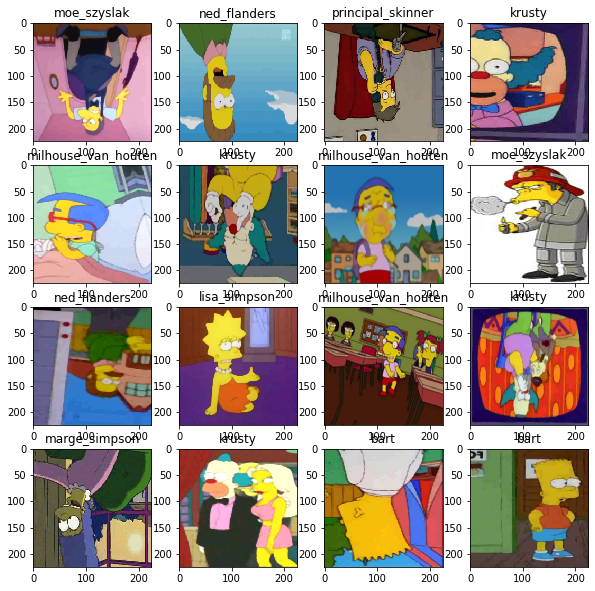

In [ ]:
ex_data = DataSequence(train, 16, augmentations=Aug_train, shuffle=True)

images, labels = next(iter(ex_data))
lst = []

fig = plt.figure(figsize=(10, 10))
plt.tight_layout()

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(image, cmap="rainbow", interpolation="none")
    plt.title(map_characters[np.argmax(label)])
    
plt.show()


In [ ]:
batch_size = 32

train_data = DataSequence(train, batch_size, augmentations=Aug_train, shuffle=True)
test_data = DataSequence(test, batch_size, augmentations=Aug_test, shuffle=False)
pred_data = DataSequence(pred, batch_size, augmentations=Aug_test, shuffle=False)

In [ ]:
# inputs = Input(shape=(200, 200, 3)) 

def insert_layer_nonseq(model, layer_regex, insert_layer_factory,
                        insert_layer_name=None, position='after'):

    # Auxiliary dictionary to describe the network graph
    network_dict = {'input_layers_of': {}, 'new_output_tensor_of': {}}

    # Set the input layers of each layer
    for layer in model.layers:
        for node in layer._outbound_nodes:
            layer_name = node.outbound_layer.name
            if layer_name not in network_dict['input_layers_of']:
                network_dict['input_layers_of'].update(
                        {layer_name: [layer.name]})
            else:
                network_dict['input_layers_of'][layer_name].append(layer.name)

    # Set the output tensor of the input layer
    network_dict['new_output_tensor_of'].update(
            {model.layers[0].name: model.input})

    # Iterate over all layers after the input
    model_outputs = []
    x = model.layers[0].output
    for layer in model.layers[1:]:

        # Determine input tensors
        layer_input = [network_dict['new_output_tensor_of'][layer_aux] 
                for layer_aux in network_dict['input_layers_of'][layer.name]]
        if len(layer_input) == 1:
            layer_input = layer_input[0]

        # Insert layer if name matches the regular expression
        if re.match(layer_regex, layer.name):
            if position == 'replace':
                x = layer_input
            elif position == 'after':
                x = layer(layer_input)
            elif position == 'before':
                pass
            else:
                raise ValueError('position must be: before, after or replace')

            new_layer = insert_layer_factory()
            
            x = new_layer(x)
            print('New layer: {} Old layer: {} Type: {}'.format(new_layer.name,
                                                            layer.name, position))
            if position == 'before':
                x = layer(x)
        else:
            x = layer(layer_input)

        # Set new output tensor (the original one, or the one of the inserted
        # layer)
        network_dict['new_output_tensor_of'].update({layer.name: x})

        # Save tensor in output list if it is output in initial model
        
        if layer.name in model.output_names:
            model_outputs.append(x)
        

    return Model(inputs=model.inputs, outputs=model_outputs)

base_model = Xception(include_top=False, weights='imagenet', input_shape=(225, 225, 3), pooling='avg')

def dropout_layer_factory():
    return Dropout(0.4)
base_model = insert_layer_nonseq(base_model, '.*pooling2d.*', dropout_layer_factory, position='before')
base_model.trainable = False    

X = Flatten()(base_model.output)

X = Dense(512, activation='relu', kernel_initializer='he_normal')(X)
 #   tf.keras.layers.LeakyReLU(alpha=0.1),
X = BatchNormalization(momentum=0.99, epsilon=1e-5, gamma_initializer="uniform")(X)
X = Dropout(0.5)(X)


X = Dense(64, activation='relu', kernel_initializer='he_normal')(X)
 #   tf.keras.layers.LeakyReLU(alpha=0.1),
X = BatchNormalization(momentum=0.99, epsilon=1e-5, gamma_initializer="uniform")(X)

outputs = Dense(9, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=outputs)
model.summary()

83697664/83683744 [==============================] - 2s 0us/step
New layer: dropout Old layer: global_average_pooling2d Type: before
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 225, 225, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 112, 112, 32  128 

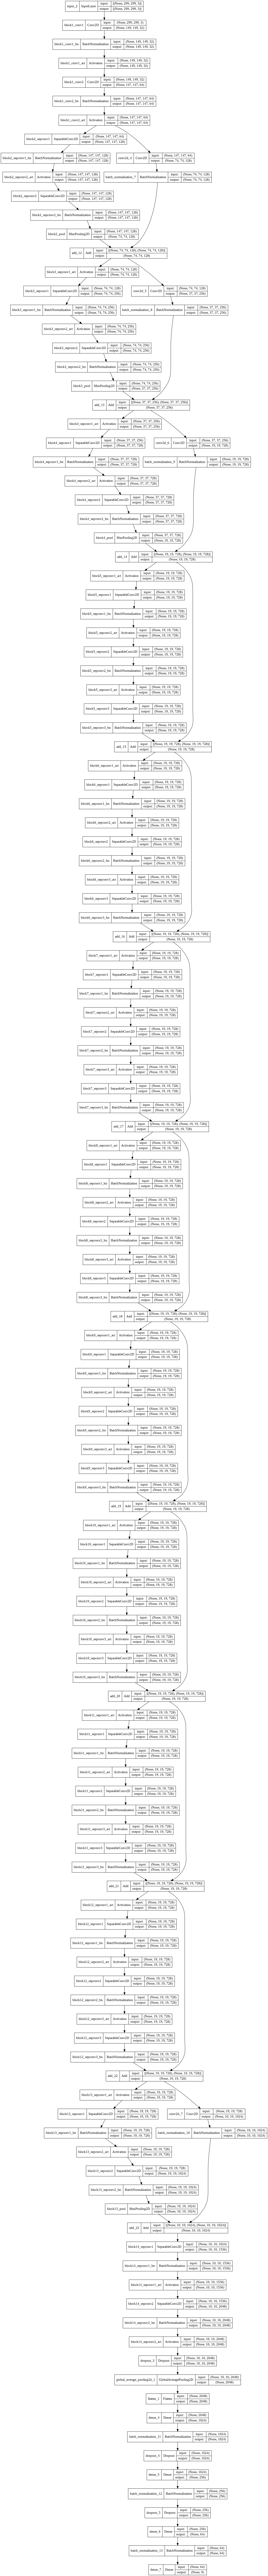

In [ ]:
plot_model(model, to_file='summary.png', show_shapes=True, show_layer_names=True)

In [ ]:
num = 2


his = {"acc" : [], "val_acc" : [], "loss" : [], "val_loss" : []}
result = []


#rl = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_delta=0.001, min_lr=0.000001)

lr_decayed_fn = (schedules.CosineDecayRestarts(
      initial_learning_rate=0.001,
      first_decay_steps=400,
      t_mul=2.0, 
      m_mul = 0.8, name =None))


for i in range(num):
  base_model.trainable = False if i == 0 else True
  model.compile(optimizer=Adam(learning_rate=lr_decayed_fn), loss="categorical_crossentropy", metrics=["accuracy"])
  if (i == 0):
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=4, verbose=1, mode='min', restore_best_weights=True)
  else:
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=20, verbose=1, mode='min', restore_best_weights=True)

  mc = ModelCheckpoint("best{:02d}".format(i+1), monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')
  
  history = model.fit(train_data, batch_size=32, epochs=35, validation_data=test_data, verbose=1, callbacks=[es, mc])
  model.load_weights("best{:02d}".format(i+1))

  result.append(model.predict(pred_data).argmax(axis=1))  

  acc = history.history['accuracy']
  his["acc"].append(acc)
  val_acc = history.history['val_accuracy']
  his["val_acc"].append(val_acc)

  loss = history.history['loss']
  his["loss"].append(loss)
  val_loss = history.history['val_loss']
  his["val_loss"].append(val_loss)

  # del model



Epoch 1/35
282/282 [==============================] - ETA: 0s - loss: 1.7458 - accuracy: 0.4473
Epoch 00001: val_loss improved from inf to 1.82178, saving model to best01
282/282 [==============================] - 326s 1s/step - loss: 1.7458 - accuracy: 0.4473 - val_loss: 1.8218 - val_accuracy: 0.5431
Epoch 2/35
282/282 [==============================] - ETA: 0s - loss: 1.3262 - accuracy: 0.5768
Epoch 00002: val_loss improved from 1.82178 to 1.24655, saving model to best01
282/282 [==============================] - 312s 1s/step - loss: 1.3262 - accuracy: 0.5768 - val_loss: 1.2466 - val_accuracy: 0.5947
Epoch 3/35
282/282 [==============================] - ETA: 0s - loss: 1.1922 - accuracy: 0.5988
Epoch 00003: val_loss improved from 1.24655 to 1.04578, saving model to best01
282/282 [==============================] - 310s 1s/step - loss: 1.1922 - accuracy: 0.5988 - val_loss: 1.0458 - val_accuracy: 0.6600
Epoch 4/35
282/282 [==============================] - ETA: 0s - loss: 1.0842 - accu

In [ ]:
his['loss'][0].extend(his['loss'][1])
his['val_loss'][0].extend(his['val_loss'][1])
his['acc'][0].extend(his['acc'][1])
his['val_acc'][0].extend(his['val_acc'][1])

fig, loss_ax = plt.subplots(figsize=(12, 8))
acc_ax = loss_ax.twinx()

loss_ax.plot(his['loss'][0], 'y', label='train loss')
loss_ax.plot(his['val_loss'][0], 'r', label='val loss')

acc_ax.plot(his['acc'][0], 'b', label='train acc')
acc_ax.plot(his['val_acc'][0], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
 model.load_weights("best{:02d}".format(i+1))

  result.append(model.predict(pred_data).argmax(axis=1))  

IndentationError: ignored

In [ ]:



if(len(pred) == len(result[1])):
  filename = 'prediction.csv'
  pred.replace(test_path, '', regex=True, inplace=True)
  pred['pred'] = result[1]
  pred.rename(columns={'path' : 'files'}, inplace=True)
  pred['pred'] = pred['pred'].map(map_characters)
  pred.sort_values(by=['files'], inplace=True)
  pred.reset_index(drop=True, inplace=True)
  pred.to_csv(filename, sep=',', na_rep='NaN', index=True)    
else:
  print("prediction error")